In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [4]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([9., 5.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [6]:
losses, models = optimise(params, model_single, exposures_single, things, 20)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[4050598.5, -650215.8],
       [-650216. , 4008933.5]], dtype=float32), 'spectrum': Array([[39020436.   ,  -348944.5  , 14256332.   ,  -178872.75 ,
         9415134.   ],
       [ -348945.2  ,  4738823.   ,  -196429.69 ,  3011463.5  ,
         -154753.31 ],
       [14256332.   ,  -196429.88 ,  6442466.   ,  -116312.625,
         4587756.5  ],
       [ -178873.19 ,  3011463.5  ,  -116312.75 ,  2261235.   ,
          -93522.44 ],
       [ 9415133.   ,  -154753.12 ,  4587756.5  ,   -93522.125,
         3430511.8  ]], dtype=float32), 'cold_mask_shift': Array([[-69311.39   ,    -82.65813],
       [   -82.6557 , -81816.21   ]], dtype=float32), 'cold_mask_rot': Array([[-134803.31]], dtype=float32)}}
Fitting Model


  0%|          | 0/20 [00:00<?, ?it/s]

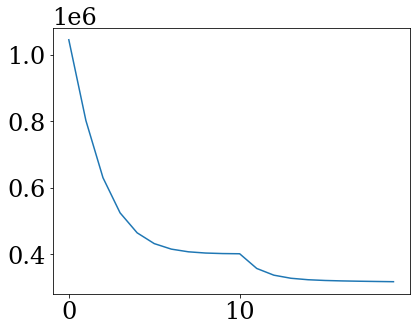

In [7]:
plt.plot(losses[-20:])

4


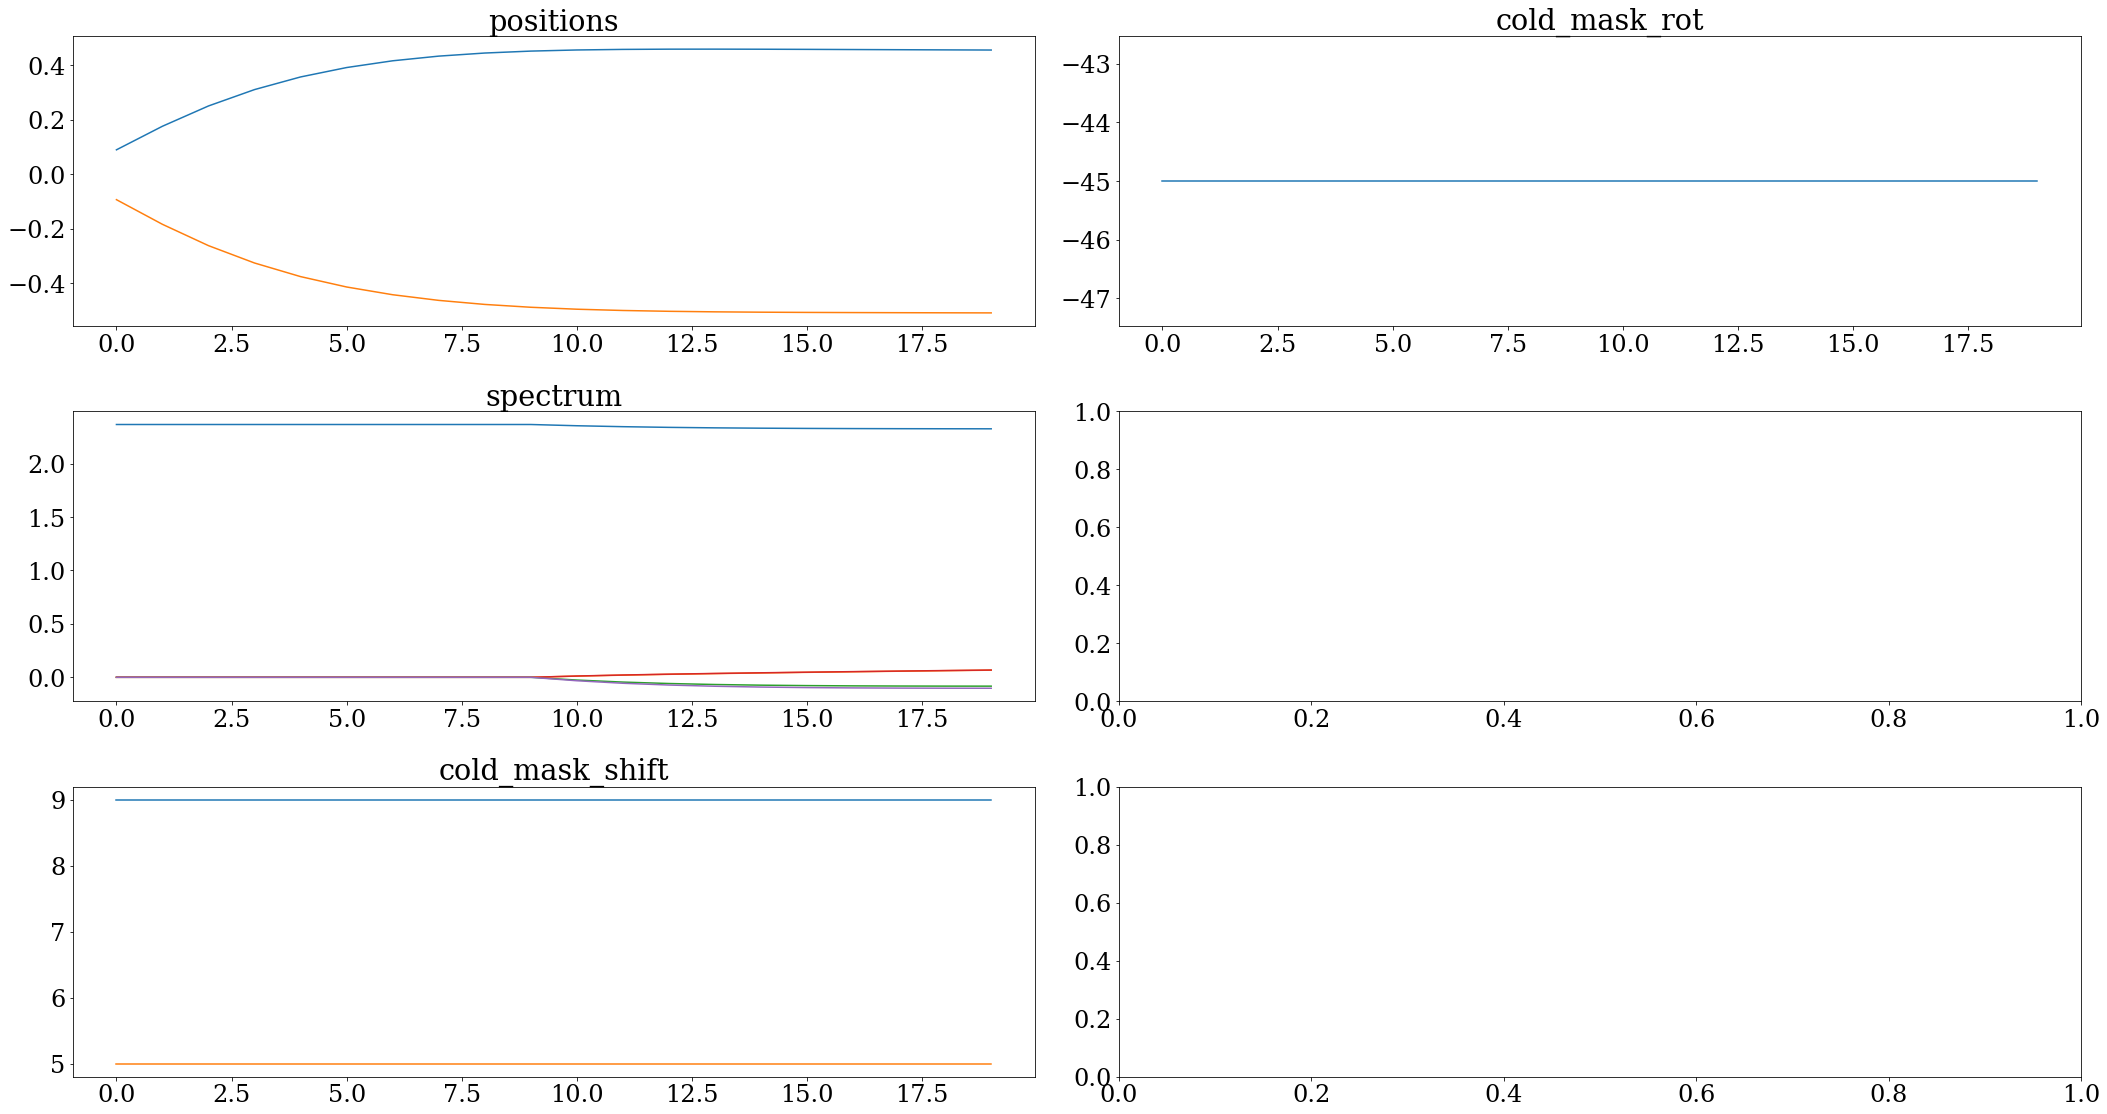

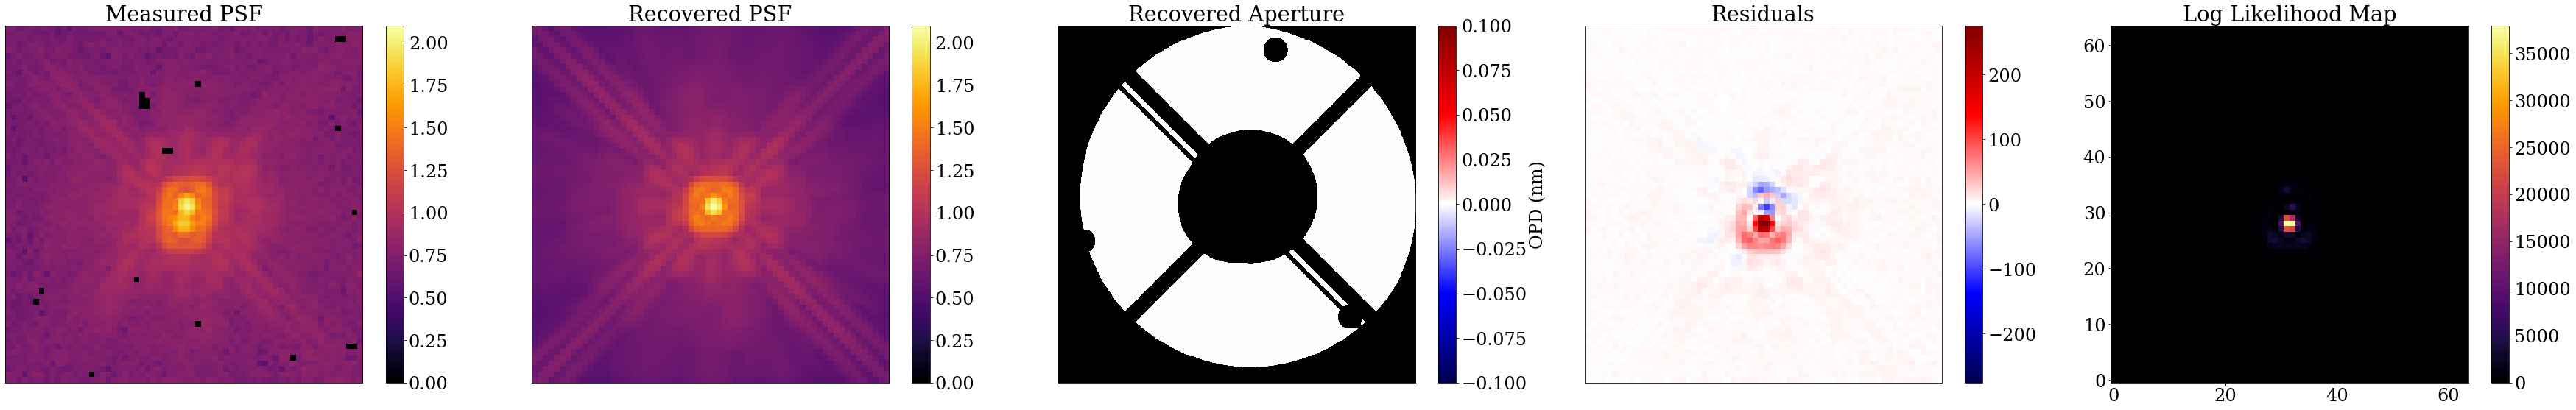

In [8]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [9]:
#potato

In [10]:
#plot_spectra(model_single, models[-1], exposures_single)

In [11]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [12]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [13]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
#things = {"primary_spectrum": opt(4e-6, 0), "secondary_spectrum": opt(4e-6, 0)}#, "contrast": opt(1e-8, 10)}
things = {"fluxes": opt(5e-11, 0)}#, "contrast": opt(5e-11, 10)}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(things.keys()))
def binary_loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def binary_optimise(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]
    
    optim, opt_state = zdx.get_optimiser(
        params, paths, optimisers
    )

    losses, models = [], []
    for i in (range(niter)):
        loss, grads = binary_loss_fn(params,exposures, model)
        #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        params = zdx.apply_updates(params, updates)

        models.append(params)
        losses.append(loss)
    
    return losses, models

In [15]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': 0.0},
    'cold_mask_rot':
    {'n8yj59glq': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'jitter':
    {'n8yj59glq': 0.6511627906976745},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': 45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [16]:
x_vals = np.linspace(-5, 5, 4)
y_vals = np.linspace(-5, 5, 4)
theta_vals = np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.asarray([1.5, 3])#np.linspace(0, 5, 2)

min_loss = np.inf
best_params = None

for x in x_vals:
    for y in y_vals:
        for theta in theta_vals:
            for r in r_vals:
                binary_params = extract_binary_params(models[-1], exposures_binary, x, y, theta, r, 0., 1.)
                #binary_params = extract_binary_params(models[-1], exposures_binary, 0, 0, 0, 0, 0., 1.)#np.log10(0.5), 1.)
                losses, bms = binary_optimise(binary_params, model_binary, exposures_binary, things, 20)
                print(losses[-1])
                if losses[-1] < min_loss and min_loss != 0.0:
                    min_loss = losses[-1]
                    best_params = bms[-1]
                

16269446.0
16123178.0
16271541.0
16138535.0
16273844.0
16154388.0
16276343.0
16170572.0
15171146.0
14980390.0
15168700.0
14970014.0
15166720.0
14963077.0
15165226.0
14959611.0
16291356.0
16170037.0
16291332.0
16165203.0
16291475.0
16160788.0
16291793.0
16156840.0
16303216.0
16612251.0
16299718.0
16607760.0
16296165.0
16602850.0
16292557.0
16597515.0
12907317.0
11716761.0
12895914.0
11673179.0
12884709.0
11630021.0
12873745.0
11587415.0
6796475.5
4847952.0
6780161.5
4801993.5
6764394.0
4759156.0
6749228.0
4719752.0
11135809.0
10141214.0
11157379.0
10219687.0
11178636.0
10297654.0
11199500.0
10374823.0
16575340.0
16557006.0
16574725.0
16553682.0
16574084.0
16550337.0
16573434.0
16546969.0
13288808.0
12219978.0
13294914.0
12224689.0
13301391.0
12230645.0
13308224.0
12237907.0
8804731.0
6707033.5
8814173.0
6737568.0
8823659.0
6768886.0
8833160.0
6800977.5
10562909.0
9108188.0
10540228.0
9011855.0
10517844.0
8917171.0
10495798.0
8824416.0
16327496.0
16236526.0
16328081.0
16236583.0
16328657

In [17]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': 0.0},
    'cold_mask_rot':
    {'n8yj59glq': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f32[]},
    'jitter':
    {'n8yj59glq': 0.6511627906976745},
    'outer_radius':
    1.146,
    'position_angle':
    f32[],
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': 45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'separation':
    f32[],
    'softening':
    2,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924
  }
)

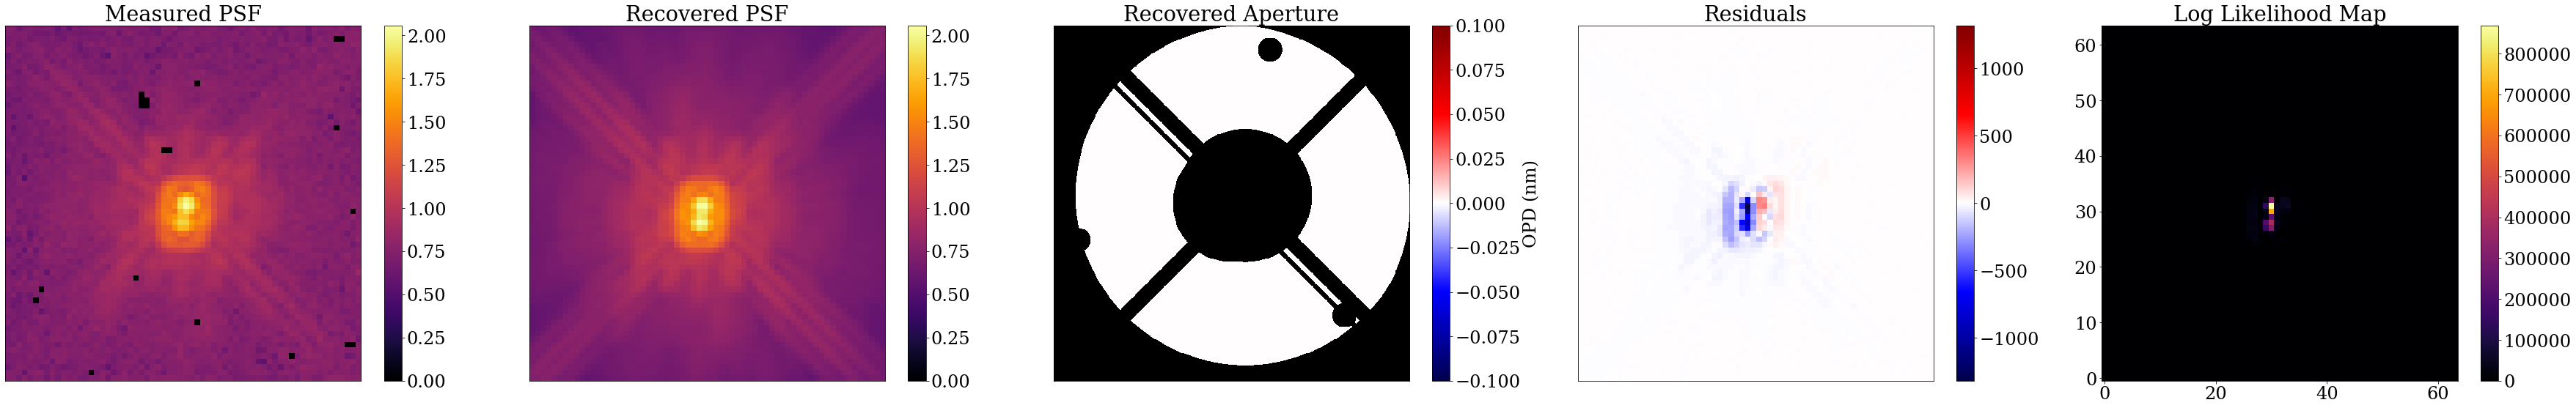

In [18]:
plot_comparison(model_binary, best_params, exposures_binary)

In [31]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-2, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*200, 60),
    "cold_mask_rot": opt(g*10, 60),
    "aberrations": opt(g*2,30),#, (150, g*0.2)),
    "bias": opt(g*20, 40)
}
groups = list(things.keys())


In [32]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 1000)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[6884428.5 , -251463.03],
       [-251463.33, 5561864.5 ]], dtype=float32), 'separation': Array([[-438152.75]], dtype=float32), 'position_angle': Array([[0.]], dtype=float32), 'primary_spectrum': Array([[28372474.  ,  1562966.9 ,  9263990.  ,  1192013.2 ,  5800337.5 ],
       [ 1562967.  ,  5021736.  ,   811615.3 ,  3084904.  ,   618378.3 ],
       [ 9263991.  ,   811615.3 ,  4432975.  ,   667450.75,  3169850.  ],
       [ 1192013.4 ,  3084904.  ,   667450.9 ,  2302695.5 ,   537777.4 ],
       [ 5800338.  ,   618378.6 ,  3169850.8 ,   537777.3 ,  2450654.2 ]],      dtype=float32), 'secondary_spectrum': Array([[28372474.  ,  1562966.9 ,  9263990.  ,  1192013.2 ,  5800337.5 ],
       [ 1562967.  ,  5021736.  ,   811615.3 ,  3084904.  ,   618378.3 ],
       [ 9263991.  ,   811615.3 ,  4432975.  ,   667450.75,  3169850.  ],
       [ 1192013.4 ,  3084904.  ,   667450.9 ,  2302695.5 ,   537777.4 ],
       [ 5800338.  ,   618378.6 ,  3169850.8 ,   537777.3 ,

  0%|          | 0/1000 [00:00<?, ?it/s]

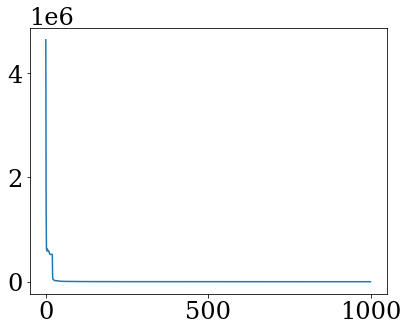

In [33]:
plt.plot(losses)

9


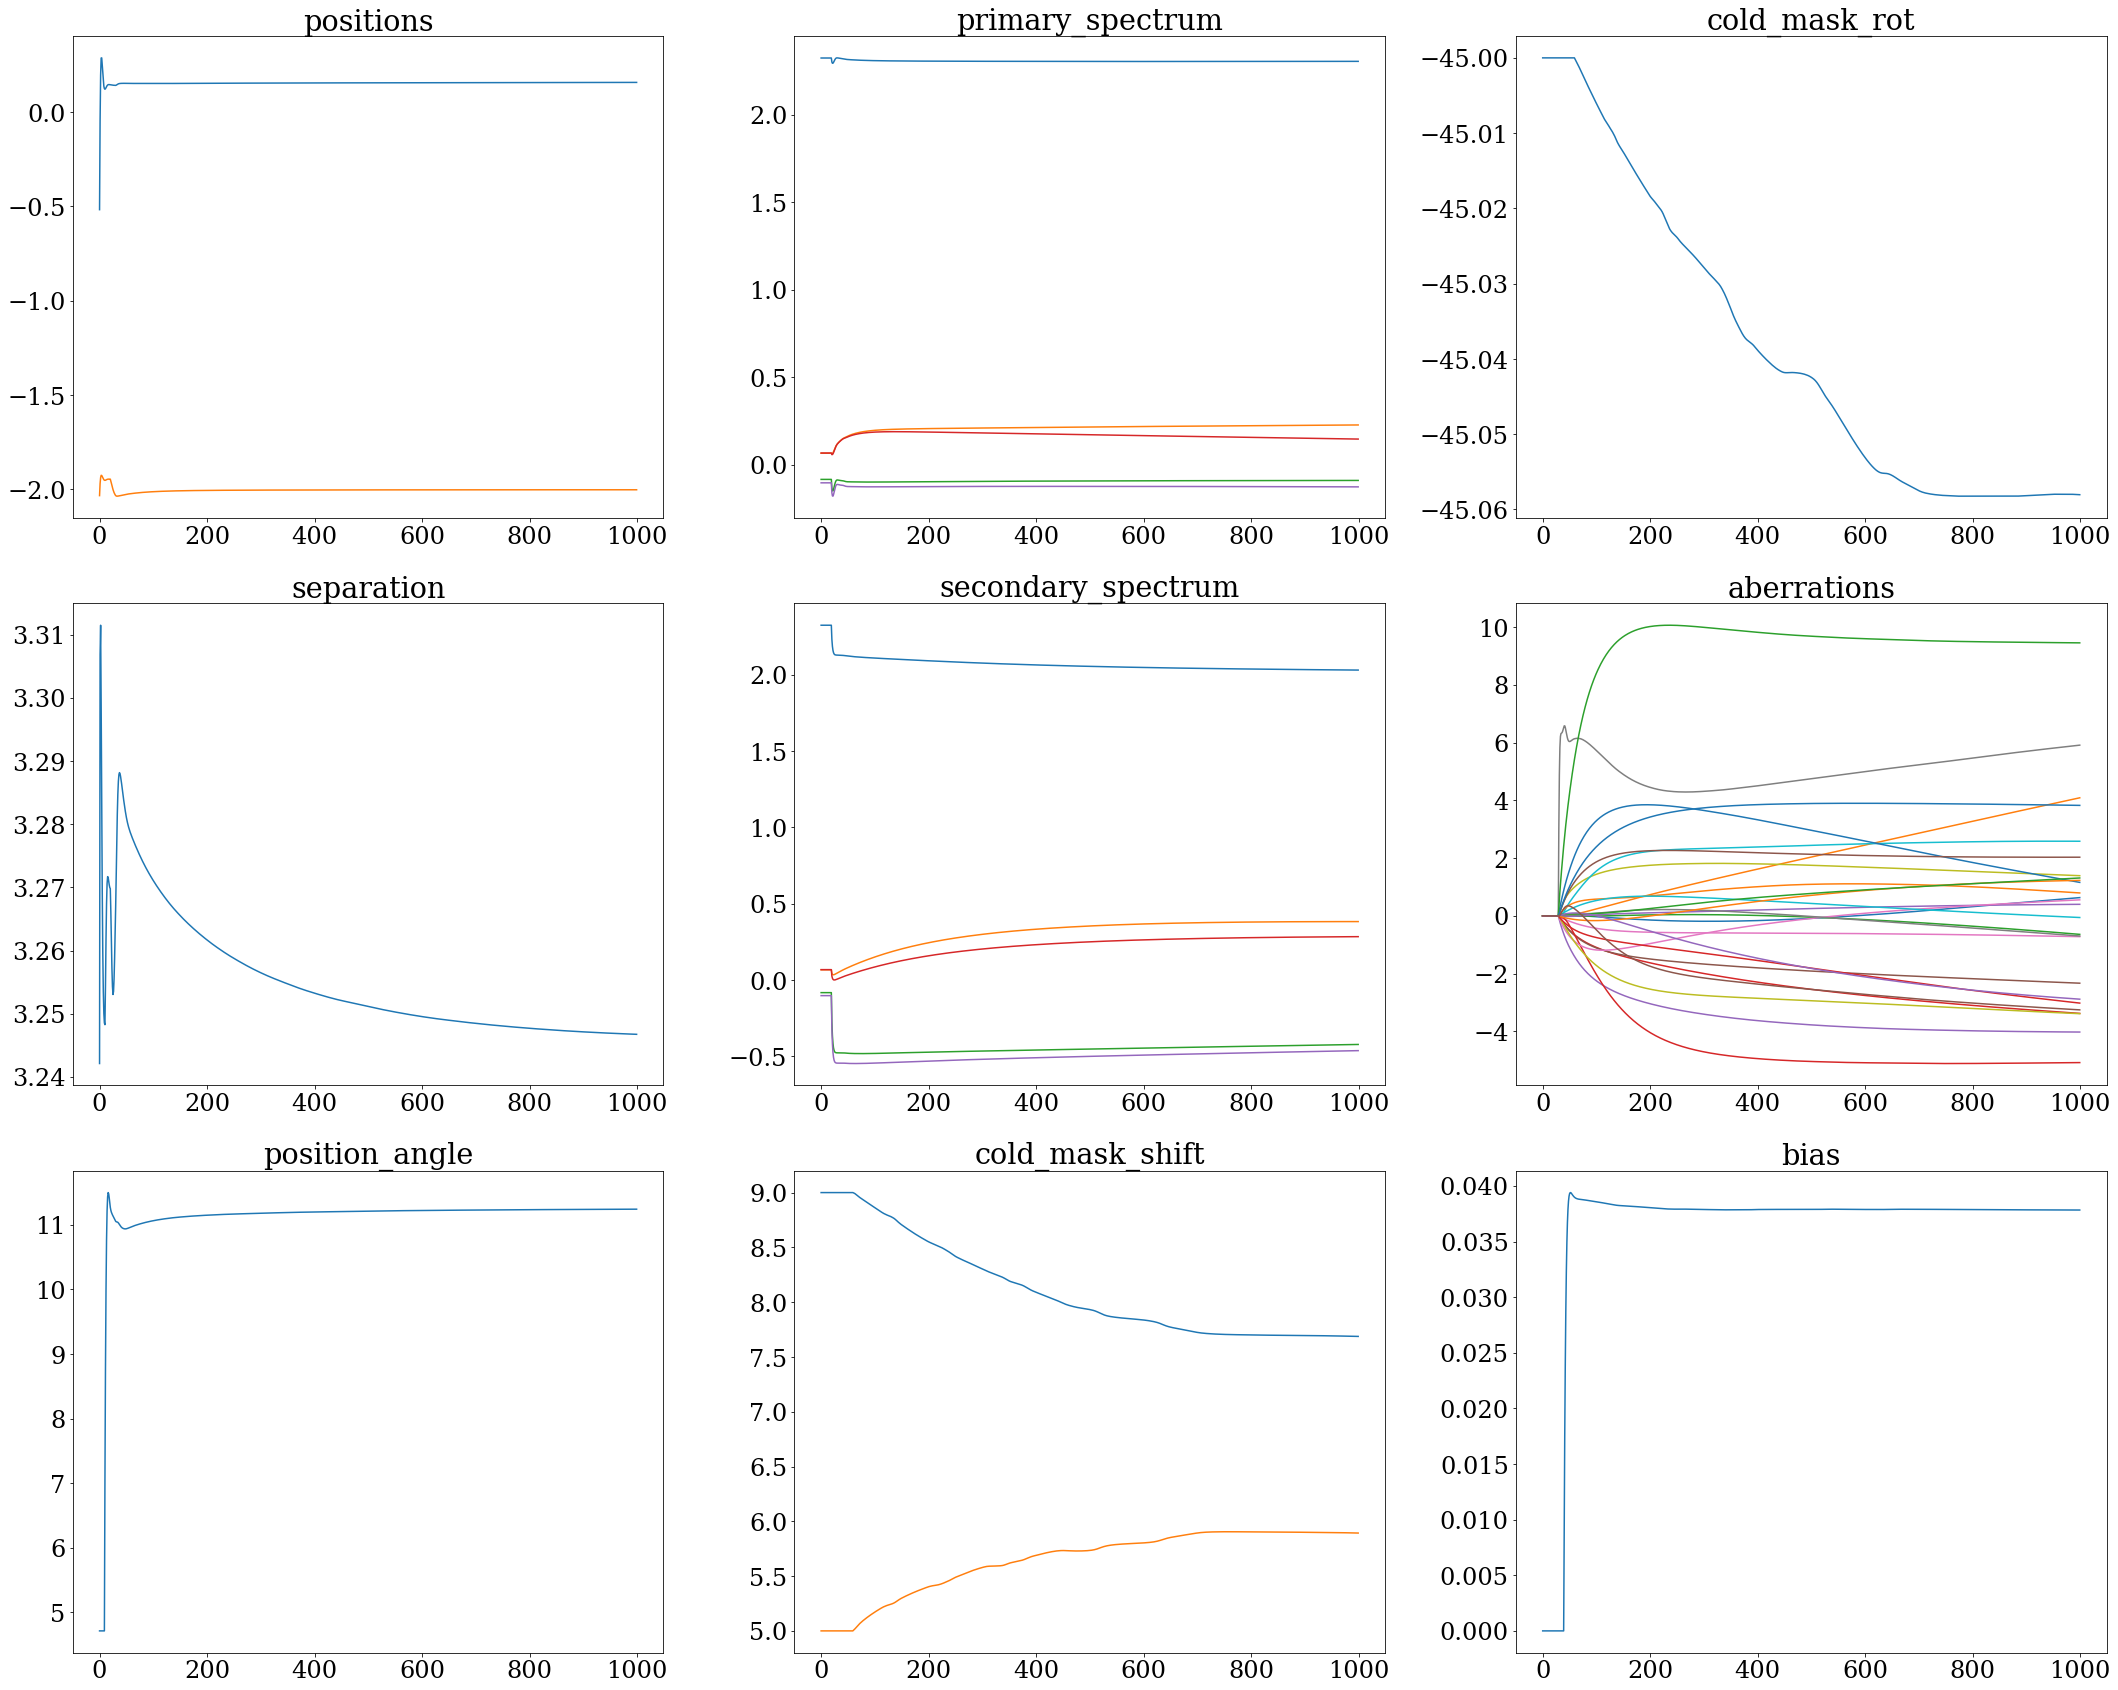

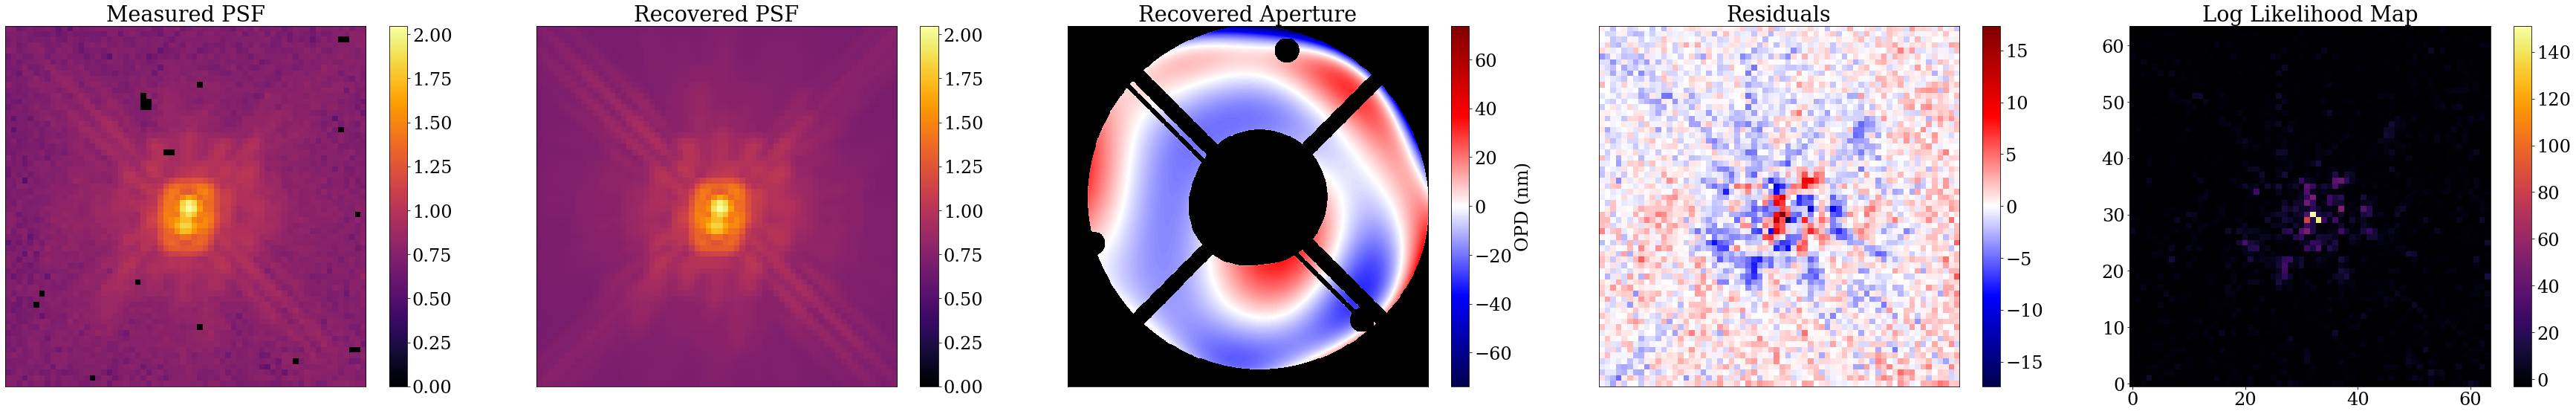

In [34]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [35]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ 0.631922  ,  4.0876527 , -0.6409875 , -3.3768086 , -4.0229907 ,
         -2.3313086 , -0.72013617,  5.910568  ,  1.3909254 ,  2.583142  ,
          1.1589681 ,  0.7929376 ,  9.452441  , -5.0805283 ,  0.3992762 ,
          2.0305305 ,  0.554083  , -0.6970362 , -3.3870375 , -0.05744915,
          3.8251443 ,  1.227672  ,  1.3115306 , -3.0206513 , -2.8848622 ,
         -3.2551312 ], dtype=float32)},
 'bias': {'n8yj59glq': Array(0.03783157, dtype=float32)},
 'cold_mask_rot': {'n8yj59glq': Array(-45.058037, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([7.687454 , 5.8928943], dtype=float32)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.07146072, dtype=float32))]),
 'jitter': {'n8yj59glq': 0.6511627906976745},
 'outer_radius': 1.146,
 'position_angle': Array(11.24334, dt

Text(0, 0.5, 'Relative Spectral Intensity')

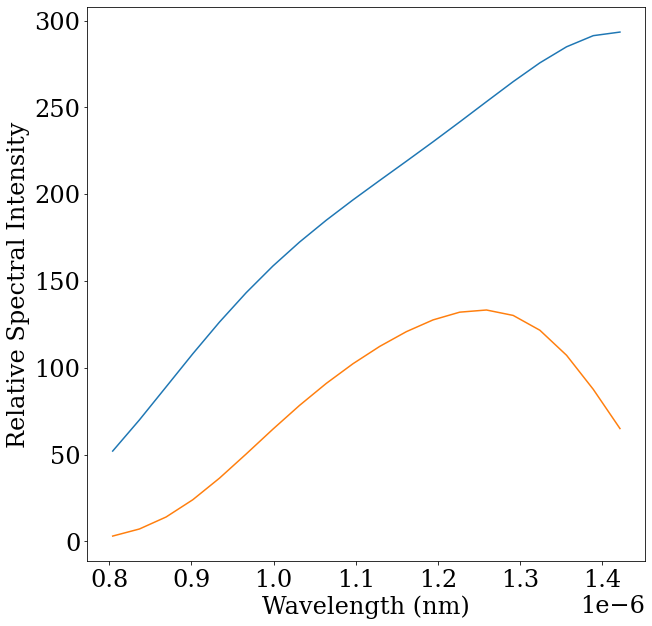

In [36]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")